In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Utils

In [13]:
from collections import defaultdict
import json
import numpy as np

class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)
            
        self.annIm_dict = defaultdict(list)        
        self.cat_dict = {} 
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:           
            self.annIm_dict[ann['image_id']].append(ann) 
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]        
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]


# Data Play-around

In [14]:
DATA_PATH = '../../datasets/deepfashion2/validation/'
annotation_file= DATA_PATH + 'instances.json'
images_dir =  DATA_PATH + 'images/'
coco= COCOParser(annotation_file, images_dir)

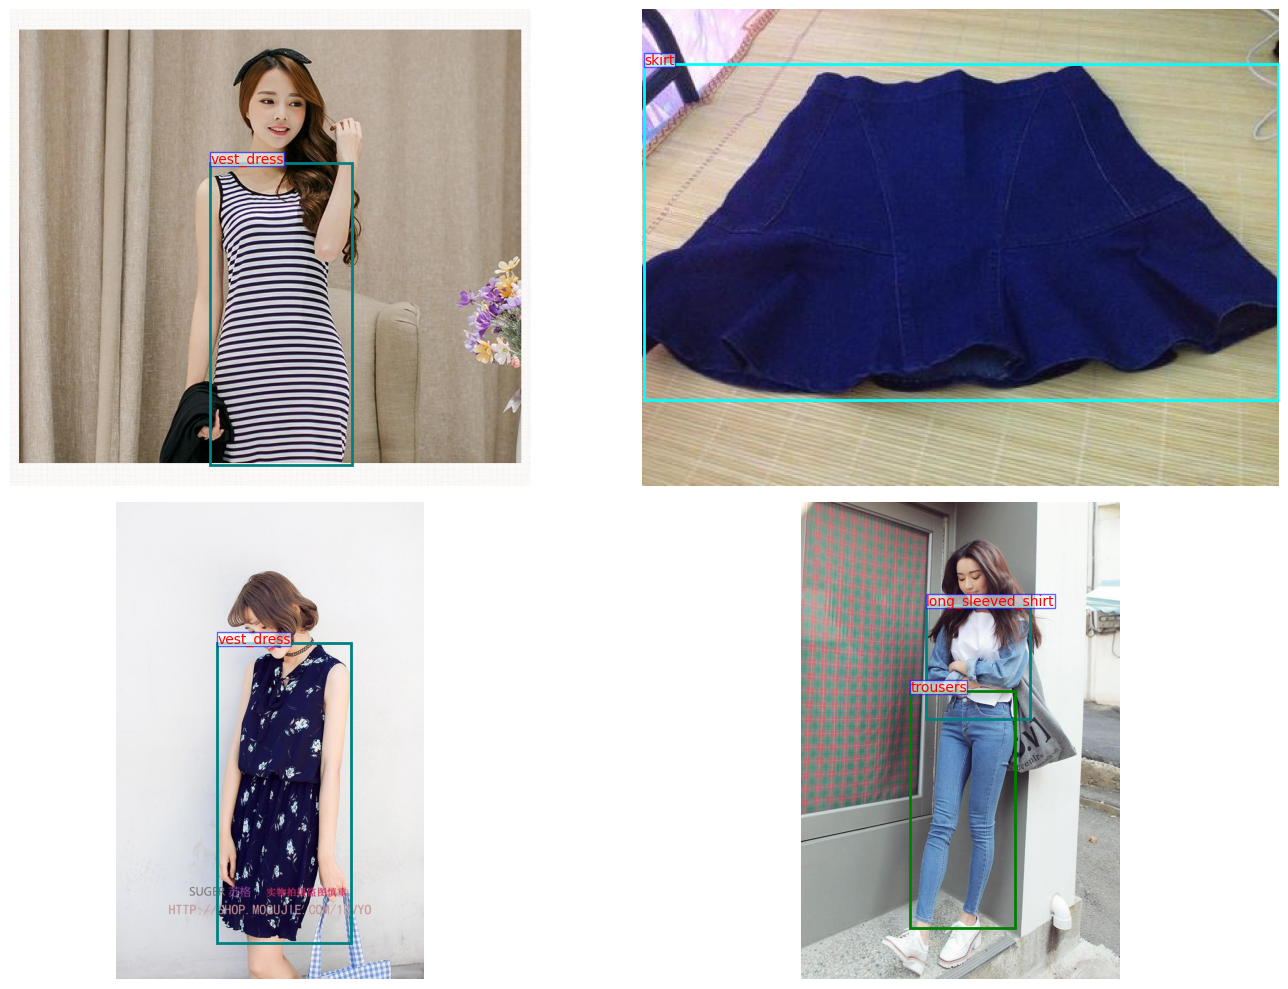

In [15]:
# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
img_ids = coco.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]
ann_ids = coco.get_annIds(selected_img_ids)


#im_licenses = coco.get_imgLicenses(selected_img_ids)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{images_dir}{str(im).zfill(6)}.jpg")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        #license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)
    
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    #ax[i].set_title(f"License: {license}")
plt.tight_layout()
plt.show()

# Inference on a random query image

In [16]:
from ultralytics import YOLO

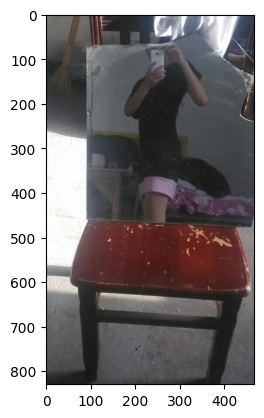

In [17]:
image = Image.open('../../datasets/deepfashion2/validation/images/000017.jpg')
plt.imshow(image)

In [18]:
# Load a model
yolo_v8 = YOLO('yolov8s.pt')  # pretrained YOLOv8n model
yolo_v5 = YOLO('yolov5su.pt')


res_v8 = yolo_v8(image)
res_v5 = yolo_v8(image)




0: 640x384 1 person, 1 chair, 1 cell phone, 152.8ms
Speed: 4.2ms preprocess, 152.8ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 chair, 1 cell phone, 103.2ms
Speed: 1.1ms preprocess, 103.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


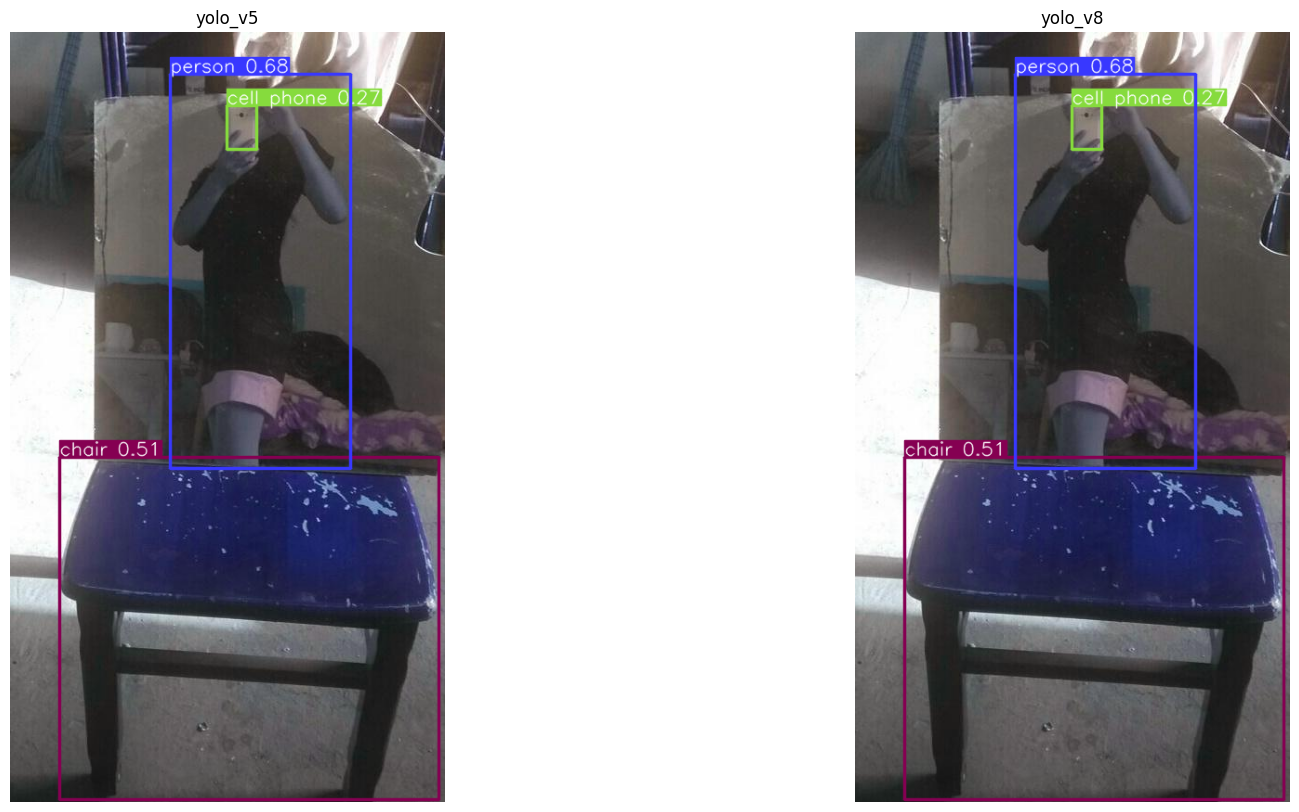

In [19]:
results = [(res_v5[0].plot(),"yolo_v5"),(res_v8[0].plot(),"yolo_v8")]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax = ax.ravel()
for i,res in enumerate(results):
    ax[i].axis('off')
    ax[i].set_title(res[1])
    ax[i].imshow(res[0])
    
plt.show()

# Yolo Finetuning

## Yolo V5

In [20]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov5nu.pt')  # load a pretrained model (recommended for training)

# Train the model with 2 GPUs
model.train(data='../data/configs/deepfashion2.yaml', batch = 10, epochs=1,device ='cpu',workers = 8)

New https://pypi.org/project/ultralytics/8.0.141 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.138 🚀 Python-3.9.17 torch-2.0.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov5nu.pt, data=../data/configs/deepfashion2.yaml, epochs=1, patience=50, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

2023-07-24 18:50:38,625 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'


WARNING ⚠️ ClearML installed but not initialized correctly, not logging this run. It seems ClearML is not configured on this machine!
To get started with ClearML, setup your own 'clearml-server' or create a free account at https://app.clear.ml
Setup instructions can be found here: https://clear.ml/docs
TensorBoard: Start with 'tensorboard --logdir /Users/akallala/git/project-visual-search/runs/detect/train5', view at http://localhost:6006/
train: Scanning /Users/akallala/git/project-visual-search/datasets/deepfashion2/train/labels.cache... 191961 images, 0 backgrounds, 0 corrupt: 100%|██████████| 191961/191961 [00:00<?, ?it/s]
val: Scanning /Users/akallala/git/project-visual-search/datasets/deepfashion2/validation/labels.cache... 32153 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32153/32153 [00:00<?, ?it/s]
Plotting labels to /Users/akallala/git/project-visual-search/runs/detect/train5/labels.jpg... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 69 weight(dec

KeyboardInterrupt: 

## Yolo V8

### Fine tuning

In [5]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Train the model with 2 GPUs
model.train(data='../data/configs/deepfashion2.yaml', batch = 10, epochs=1,device ='cpu',workers = 8)

New https://pypi.org/project/ultralytics/8.0.141 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.138 🚀 Python-3.9.17 torch-2.0.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=../yolov5/data/deepfashion2-3k.yaml, epochs=1, patience=50, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

KeyboardInterrupt: 

To check the training :

In [ ]:
!tensorboard --logdir runs